# Reading data from CSV file and Annotating Continuous Data

# Loading CSV file
- Use pd.read_csv function to load data
- Call transpose since mne expects channels to be formatted as rows
- set sample frequency 
- set meas_date date to 0 to avoid Ambiguous operation error


## Plotting Events
- First column measures sample, second column is place holder, third column is label

## Plotting Annotations
- First column is onset, seconds column is duration, third column is label


- [Events](https://mne.tools/stable/glossary.html#term-events)
- [read_events()](https://mne.tools/stable/generated/mne.read_events.html#mne-read-events)
- [Work around for "RuntimeError: Ambiguous operation" (read_annotations) -> raw.set_meas_date(0) ](https://github.com/mne-tools/mne-python/issues/5908#issuecomment-461865564)
- [Read Annotations](https://mne.tools/stable/generated/mne.read_annotations.html#mne-read-annotations)


https://notebook.community/mne-tools/mne-tools.github.io/0.14/_downloads/plot_objects_from_arrays 

Creating RawArray with float64 data, n_channels=8, n_times=64
    Range : 0 ... 63 =      0.000 ...     0.246 secs
Ready.


/tmp/ipykernel_4048/2588009631.py:13: RuntimeWarning: This filename (events.txt) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events("events.txt")


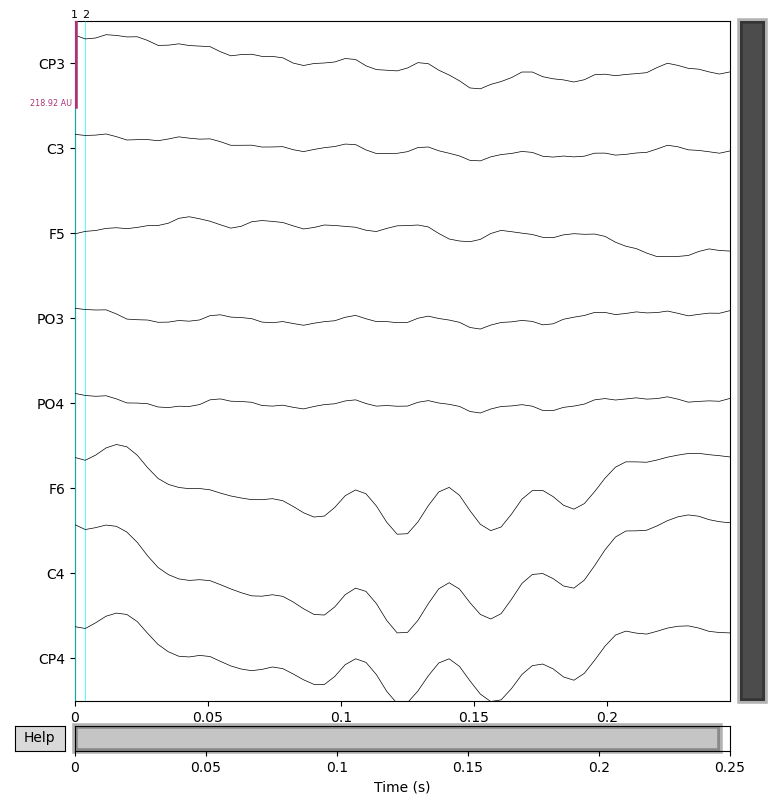

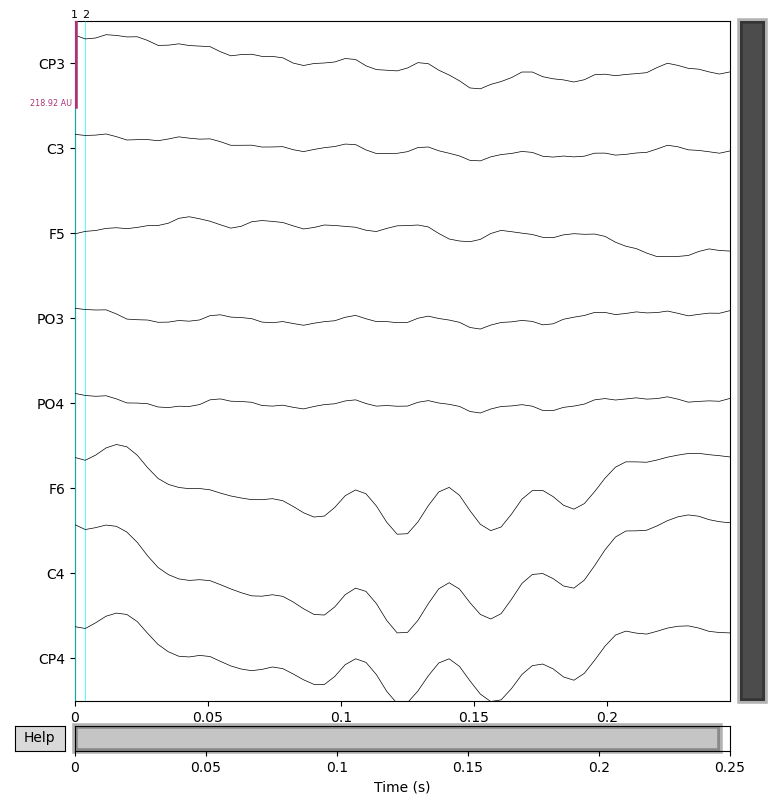

In [96]:
import torch
import pandas as pd 
import mne

data = pd.read_csv('new_data.csv', usecols = [i+1 for i in range(8)]).transpose()
sfreq = 256
ch_names = ['CP3', 'C3', 'F5',  'PO3', 'PO4', 'F6', 'C4',  'CP4' ]
info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
raw = mne.io.RawArray(data, info)
raw.set_meas_date(0)

# Plot events
events = mne.read_events("events.txt") 
raw.plot(events=events)

# Plot Annotations
# annot_from_file = mne.read_annotations('saved-annotations2.csv')
# raw.set_annotations(annot_from_file)
#raw.plot()

# worked after doing pip install mne and opening basic python file and running python mne.py (test file)